# Surfacing Promotions M2

In [1]:
import dotenv
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import seaborn as sns
import sys
import trino

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(src_path)

from glovo_experimentation_analytics.analytics.experiment import Experiment
from long_term_exp_impact import make_inference
from long_term_exp_impact.config import METRICS
from long_term_exp_impact.load_data import get_harmony_data, agg_harmony_data, create_metrics_query_config, _get_starburst_engine
from long_term_exp_impact.inference import add_metrics_at_unit_level, get_metrics_point_estimates
from long_term_exp_impact.metric import parse_metrics
from src import query_engines, dataframe_visualizer

q = query_engines.QueryEngines()

# Q1: What are the different experiment ids

In [4]:
QUERY_NAME = 'experiments.sql' # With sql
START_DATE = "'2024-07-01'"
END_DATE = "'2024-12-02'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=QUERY_NAME
    
)

df  = q.query_run_starburst()
df

,experiment_toggle_id,experiment_id,first_exposure_date
0,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10060-ZAP_SURFACING_PROMO...,2024-07-01
1,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10715-ZAP_SURFACING_PROMO...,2024-07-04
2,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10715-ZAP_SURFACING_PROMO...,2024-07-04
3,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11134-ZAP_SURFACING_PROMO...,2024-07-18
4,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11986-ZAP_SURFACING_PROMO...,2024-08-19
5,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11986-ZAP_SURFACING_PROMO...,2024-08-26
6,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12294-ZAP_SURFACING_PROMO...,2024-09-03
7,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12327-ZAP_SURFACING_PROMO...,2024-09-05
8,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12371-ZAP_SURFACING_PROMO...,2024-09-06
9,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12371-ZAP_SURFACING_PROMO...,2024-09-17


In [7]:
df['experiment_id'].iloc[11]

'ZAP_SURFACING_PROMOS-13539-ZAP_SURFACING_PROMOS_FF-13490'

# Q2: Check the evolution of variants

In [10]:
QUERY_NAME = 'exposures.sql' # With sql
START_DATE = "'2024-10-01'"
END_DATE = "'2024-12-02'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=None
    
)

df  = q.query_run_starburst()
df.head()

Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/ccdeb002dce48eec05a4437c9025ae754155900f3e878efb0abc426497cb5291


,customer_id,variant,first_exposure_at
0,23994439,Promotions enabled,2024-11-02
1,163475141,Promotions enabled,2024-11-22
2,76140559,Control Group,2024-11-07
3,38579236,Control Group,2024-11-01
4,148775812,Control Group,2024-10-31


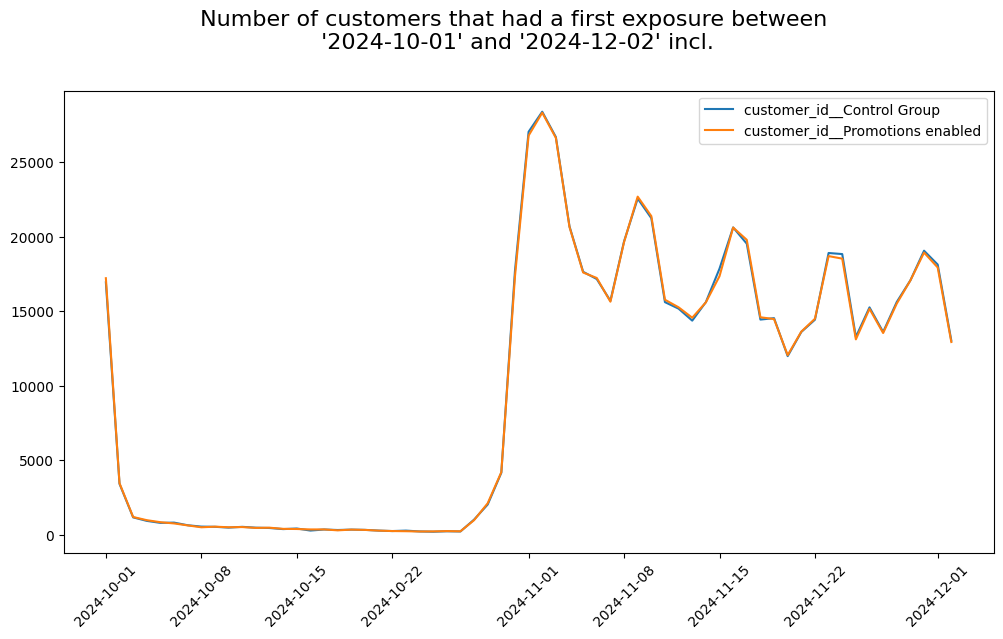

In [12]:
tmp = df.copy()

tmp['first_exposure_at'] = pd.to_datetime(tmp['first_exposure_at'])
grouped = tmp.groupby(['first_exposure_at','variant'])['customer_id'].nunique().reset_index()
grouped.sort_values(by=['first_exposure_at','variant'],ascending=[True,True], inplace=True)
pivot = grouped.pivot(index = 'first_exposure_at', columns='variant', values=['customer_id'])
pivot.columns = [f'{col[0]}__{col[1]}' for col in pivot.columns]
pivot = pivot.reset_index()
pivot = pivot.fillna(0)

v = dataframe_visualizer.DataFrameVisualizer(pivot)

plot_params = [
    {
        'plot_type': 'lineplot', 
        'x_column': 'first_exposure_at', 
        'y_columns': ['customer_id__Control Group', 'customer_id__Promotions enabled'],
        'colors': ['blue', 'orange'],
        'legend': True
    }
]

figure_params = {
    'n_plots': 1,
    'fig_length': 12,
    'fig_height': 6, 
    'x_rotation': 45,
    'x_limits': None, 
    'y_limits': None, 
    'title': f' Number of customers that had a first exposure between \n {START_DATE} and {END_DATE} incl.'
}

v.plot(figure_params=figure_params, plot_params=plot_params)


# Q3: Harmony metric

In [12]:
dotenv.load_dotenv()
conn = _get_starburst_engine()

In [13]:
exp_exposures_sql_path = "queries/exposures_harmony.sql"
exp_exposures_sql_config = {
    'end_date':"2024-11-24",
    'num_days':29
}
exp_metrics_query_config = create_metrics_query_config(
    end_date="2024-11-24",
    num_days=29,
    city_codes="all"
)

In [14]:
exp_df = get_harmony_data(
    conn=conn,
    exposures_sql_path=exp_exposures_sql_path,
    exposure_sql_config=exp_exposures_sql_config,
    metrics_query_config=exp_metrics_query_config
)

Started collecting data for harmony metrics ...
Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/0f1ff6df59ad6cd1b01b34ab1fcdd0906d6e7774bd45f9dafc80f5fce789531c
Started collecting data for customer exposures using your query ...
Started processing the data to create the final dataset for analysis ...
Loading data is completed.


In [30]:
exp_df_agg = exp_df.pipe(agg_harmony_data, groupby_cols=('customer_id','variant'))

print(exp_df_agg.shape)
exp_df_agg.head()

(1533623, 14)


,customer_id,variant,total_orders_cancelled,total_orders_delivered,total_dt_minutes,total_cdt_minutes,total_orders_created,total_long_orders,total_late_orders,total_cpo,total_cm,total_ads_revenue,total_delivered_orders_eta,one
0,220,Control Group,0.0,7.0,145.650000,96.183333,7.0,0.0,0.0,28.26380,23.633874,1.346570,7.0,1
1,223,Promotions enabled,1.0,11.0,299.350000,199.350000,12.0,0.0,1.0,33.53815,13.968854,0.000000,11.0,1
2,273,Promotions enabled,0.0,3.0,67.866667,37.000000,3.0,0.0,0.0,9.53630,-46.937800,1.132667,3.0,1
3,287,Promotions enabled,0.0,10.0,263.316667,159.791667,10.0,0.0,0.0,24.25410,68.453500,0.000000,9.0,1
4,296,Promotions enabled,0.0,3.0,108.233333,69.916667,3.0,1.0,0.0,6.21120,14.851300,1.058762,2.0,1


In [31]:
variant_map = {
    "Control Group": "control",
    "Promotions enabled": "treatment"
}

exp_df_agg['variant'] = exp_df_agg['variant'].map(variant_map)

In [32]:
alpha=0.1

results = make_inference(
    df=exp_df_agg,
    alpha=alpha
)

results

{'estimand': 'relative effect on 1y CM',
 'point_estimate': -0.0014757835728109493,
 'ci_low': -0.009104585666651285,
 'ci_upp': 0.006153018521029387,
 'std_err': 0.004637982352253042,
 'alpha': 0.1,
 'n_largest': 768472}

In [34]:
proxy_results = get_metrics_point_estimates(add_metrics_at_unit_level(exp_df_agg, parse_metrics(METRICS)))

proxy_results

{'m_cancellation_rate': {'control': 0.0301106264138789,
  'treatment': 0.030017727122772602},
 'm_customer_dt': {'control': 34.50513361814363,
  'treatment': 34.54731095377211},
 'm_courier_dt': {'control': 16.629808796119807,
  'treatment': 16.64180049414764},
 'm_orders_created': {'control': 3.0390489178525697,
  'treatment': 3.0449283866844583},
 'm_long_orders_rate': {'control': 0.0771564920981578,
  'treatment': 0.07728711038270031},
 'm_late_orders_rate': {'control': 0.049992950819268224,
  'treatment': 0.049794457606151594},
 'm_cpo': {'control': 2.8387333105573194, 'treatment': 2.839893994559682},
 'm_cm': {'control': 4.3537633707272105, 'treatment': 4.342134461271897},
 'm_ads': {'control': 0.7998973281059885, 'treatment': 0.8025184199716409},
 'units': {'control': 768472, 'treatment': 765151}}

# Q4: Flickering between versions of the experiments

There is no problem, as all the experiment occurs in the same experiment version - as checked in Q1

# Q5: Order level metrics

In [34]:
QUERY_NAME = 'metrics_customer_level.sql' # With sql
START_DATE = "'2024-10-26'"
END_DATE = "'2024-11-22'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=None
    
)

df  = q.query_run_starburst()
df

/Users/jordicremades/Documents/repos/central-node/src/query_engines.py:138: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/0773460739bcce10050f77bc45a27facab220f356708a0238d9297587d262f04


,customer_id,variant,first_exposure_at,groceries_delivered_orders,groceries_total_gmv,check_groceries_delivered_orders,groceries_delivered_orders_with_discounts,groceries_discounted_gmv
0,141550048,Promotions enabled,2024-11-05,1,1.623655,1,1,2.563715
1,66661482,Control Group,2024-11-08,0,0.000000,0,0,0.000000
2,19331470,Control Group,2024-11-03,15,262.854923,15,2,1.067367
3,50897496,Control Group,2024-11-17,1,11.798021,1,0,0.000000
4,32549025,Promotions enabled,2024-11-18,0,0.000000,0,0,0.000000
...,...,...,...,...,...,...,...,...
882421,168824082,Control Group,2024-11-10,0,0.000000,0,0,0.000000
882422,145090484,Promotions enabled,2024-11-09,0,0.000000,0,0,0.000000
882423,162105786,Promotions enabled,2024-11-10,0,0.000000,0,0,0.000000
882424,181172997,Control Group,2024-11-14,0,0.000000,0,0,0.000000


In [38]:
# Customer split
df.groupby('variant')[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df['customer_id'].nunique())

,customer_id,perc
,nunique,
variant,,
Control Group,441288,0.500085
Promotions enabled,441138,0.499915


In [45]:
df['perc_gmv_from_discounts'] = df['groceries_discounted_gmv']/df['groceries_total_gmv']
df['perc_gmv_from_discounts'] = df['perc_gmv_from_discounts'].fillna(0)

df['aov'] = df['groceries_total_gmv']/df['groceries_delivered_orders']
df['aov'] = df['aov'].fillna(0)

In [47]:
METRIC_NAME = 'perc_gmv_from_discounts'

unique_customers = df.groupby('variant')['customer_id'].nunique()
metric = df.groupby('variant')[METRIC_NAME].sum()

result = metric / unique_customers
result_df = result.reset_index(name='metric')
result_df

,variant,metric
0,Control Group,0.011011
1,Promotions enabled,0.012023


                                              Experiment Information                                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃              ┃              ┃               ┃              ┃               ┃             ┃       ┃        Alpha ┃
┃ Name         ┃ Hypothesis   ┃          Date ┃      Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing    │ New          │ 2024-10-26 to │  ['Groceries │     ['Control │        True │  0.05 │       0.0083 │
│ promos for   │ surfacing    │    2024-11-22 │    delivered │       Group', │             │       │              │
│ Groceries    │ promotions   │               │     orders', │   'Promotions │             │       │              │
│              │ will         │               │   'Groceries │     enabled'] │             │       │              │
│              │ increase the │               │    delivered │               │             │       │              │
│              │ number of    │               │  orders with │               │             │       │              │
│              │ customers    │               │  discounts', │               │             │       │              │
│              │ that         │               │   'Groceries │               │             │       │              │
│              │ interact     │               │  total GMV', │               │             │       │              │
│              │ with         │               │   'Groceries │               │             │       │              │
│              │ Promotions   │               │   discounted │               │             │       │              │
│              │              │               │        GMV', │               │             │       │              │
│              │              │               │   'Groceries │               │             │       │              │
│              │              │               │    delivered │               │             │       │              │
│              │              │               │    AOV Eur', │               │             │       │              │
│              │              │               │  'Percentage │               │             │       │              │
│              │              │               │     GMV from │               │             │       │              │
│              │              │               │  Discounts'] │               │             │       │              │
└──────────────┴──────────────┴───────────────┴──────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED ORDERS                                                                                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,1.294044,1.299419,0.005375,-0.009825,0.020575,0.350842,0.005761,False


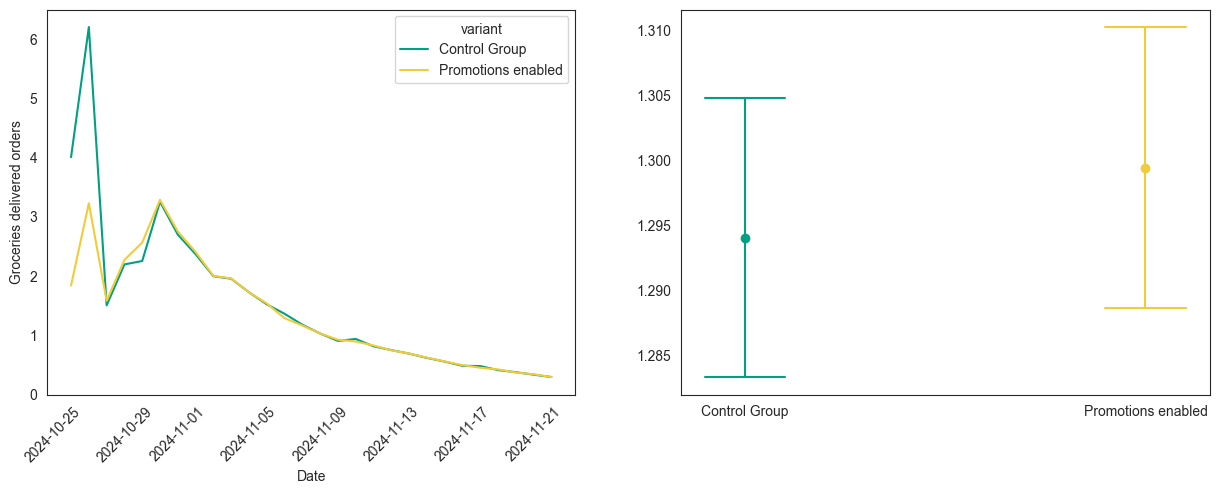

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED ORDERS WITH DISCOUNTS                                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.305914,0.316298,0.010384,0.005368,0.015401,4.731232e-08,0.001901,True


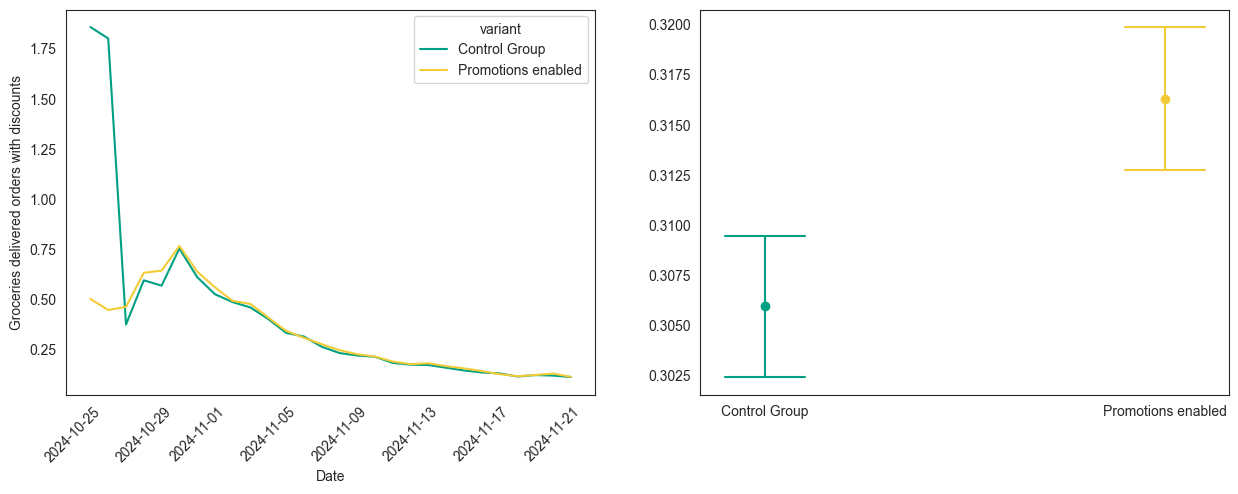

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES TOTAL GMV                                                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,24.72583,24.752453,0.026623,-0.315799,0.369045,0.837476,0.129791,False


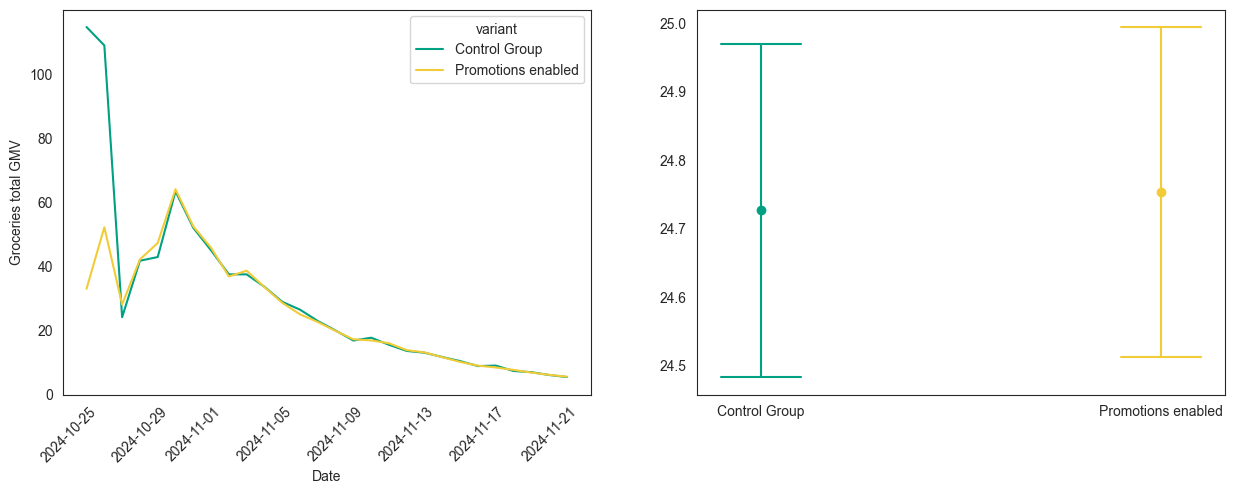

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DISCOUNTED GMV                                                                                        │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.485854,0.504944,0.019089,0.006349,0.03183,0.000077,0.004829,True


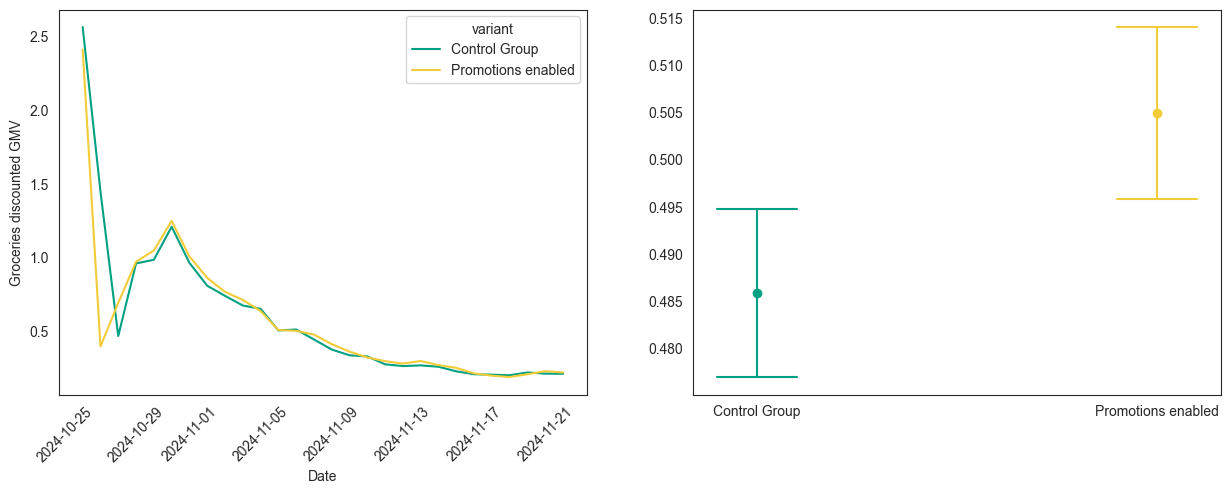

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED AOV EUR                                                                                     │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,8.515422,8.5209,0.005478,-0.069533,0.080489,0.847206,0.028432,False


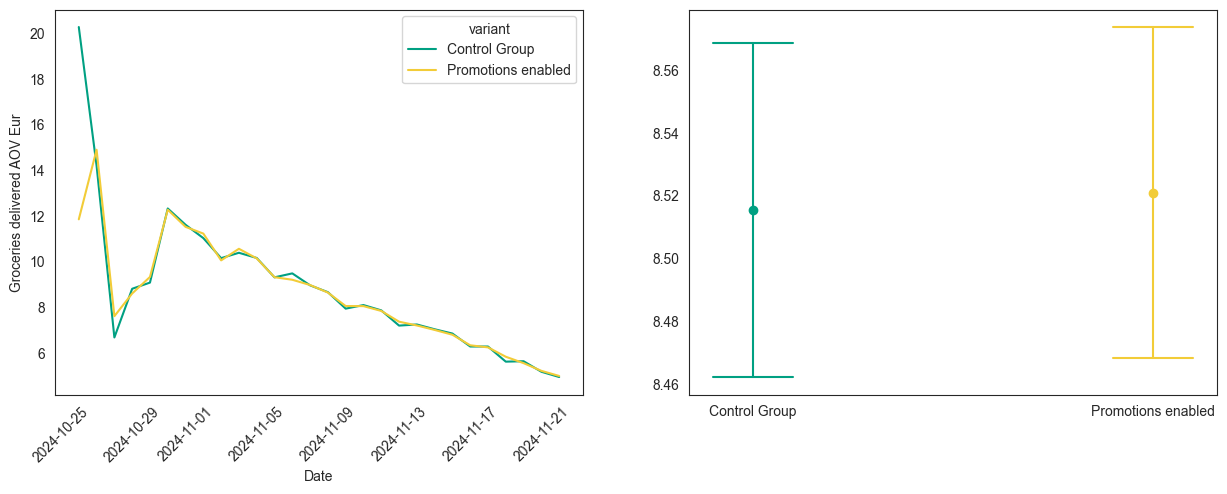

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ PERCENTAGE GMV FROM DISCOUNTS                                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.011011,0.012023,0.001012,-0.000357,0.002381,0.051163,0.000519,False


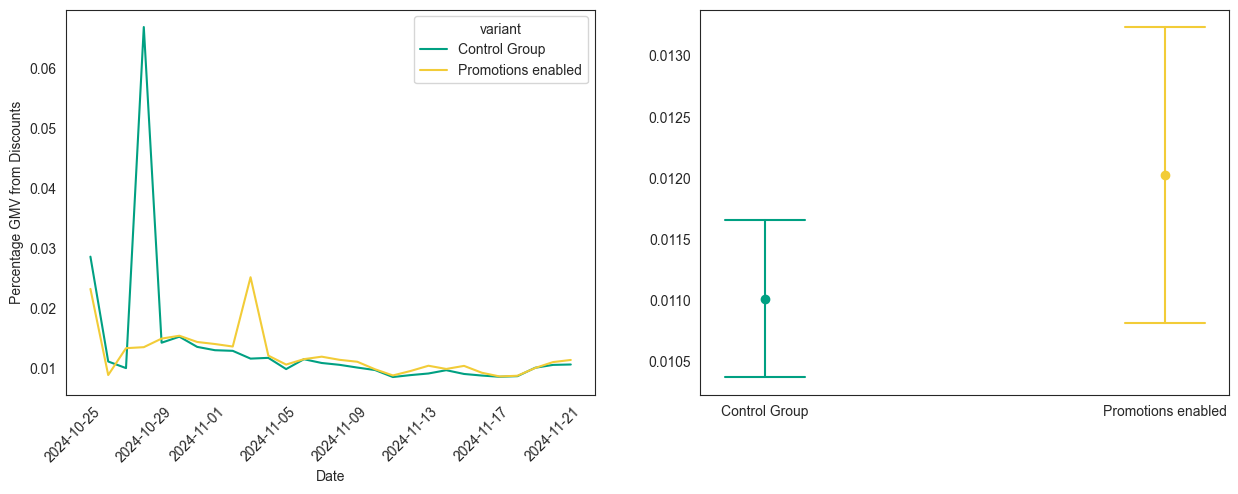

In [ ]:
from glovo_experimentation_analytics.analytics.experiment import Experiment

df['date'] = pd.to_datetime(df['first_exposure_at'])

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "New surfacing promotions will increase the number of customers that interact with Promotions",
        "start_date": "2024-10-26",
        "end_date": "2024-11-22",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "Groceries delivered orders",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_orders",
            },   
            {
                "metric_name": "Groceries delivered orders with discounts",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_orders_with_discounts",
            },
            {
                "metric_name": "Groceries total GMV",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_total_gmv",
            },  
            {
                "metric_name": "Groceries discounted GMV",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_discounted_gmv",
            },   
            {
                "metric_name": "Groceries delivered AOV Eur",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "aov",
            },   
            {
                "metric_name": "Percentage GMV from Discounts",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "perc_gmv_from_discounts",
            },   
        ],    
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": True
    }

exp_fin = Experiment.from_dict(experiment_config)
exp_fin.full_analysis()

# Q6: Session level metrics

In [49]:
QUERY_NAME = 'metrics_sessions_customer_level.sql' # With sql
START_DATE = "'2024-10-26'"
END_DATE = "'2024-11-22'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=None  
)

df  = q.query_run_starburst()
df

/Users/jordicremades/Documents/repos/central-node/src/query_engines.py:138: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/69cd66f4c086b723e306321dc839136f54dda56b753b8ec364ba1d6ddd484140


,customer_id,variant,first_exposure_at,banner_impressions,distinct_banner_impressions_per_session,widget_collection_impressions,collection_opened,distinct_collection_opened_per_session,store_access_session,order_created_session
0,157639868,Control Group,2024-10-31,0,0,0,365,277,28,4
1,167757047,Promotions enabled,2024-11-07,12,5,9,119,104,12,1
2,164209831,Promotions enabled,2024-11-19,0,0,0,1,1,1,0
3,180743434,Control Group,2024-11-06,0,0,0,20,10,1,0
4,134507548,Control Group,2024-11-09,0,0,0,84,63,5,2
...,...,...,...,...,...,...,...,...,...,...
882421,144449405,Control Group,2024-11-14,0,0,0,1,1,1,0
882422,172938820,Control Group,2024-11-05,3,2,0,33,25,3,2
882423,133190028,Promotions enabled,2024-11-06,0,0,0,78,66,3,0
882424,142797779,Promotions enabled,2024-11-15,0,0,0,1,0,2,1


In [52]:
# Customer split
df.groupby('variant')[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df['customer_id'].nunique())

,customer_id,perc
,nunique,
variant,,
Control Group,441288,0.500085
Promotions enabled,441138,0.499915


In [50]:
df.columns

Index(['customer_id', 'variant', 'first_exposure_at', 'banner_impressions',
       'distinct_banner_impressions_per_session',
       'widget_collection_impressions', 'collection_opened',
       'distinct_collection_opened_per_session', 'store_access_session',
       'order_created_session'],
      dtype='object')

In [53]:
METRIC_NAME = 'widget_collection_impressions'

unique_customers = df.groupby('variant')['customer_id'].nunique()
groceries_with_discounts = df.groupby('variant')[METRIC_NAME].sum()

result = groceries_with_discounts / unique_customers
result_df = result.reset_index(name='metric')
result_df

,variant,metric
0,Control Group,0.000204
1,Promotions enabled,4.489568


                                              Experiment Information                                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃              ┃              ┃               ┃              ┃               ┃             ┃       ┃        Alpha ┃
┃ Name         ┃ Hypothesis   ┃          Date ┃      Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing    │ New          │ 2024-07-04 to │ ['Collectio… │     ['Control │        True │  0.05 │       0.0100 │
│ promos for   │ surfacing    │    2024-08-16 │ impressions… │       Group', │             │       │              │
│ Groceries    │ promotions   │               │    'Distinct │   'Promotions │             │       │              │
│              │ will         │               │ Collection_… │     enabled'] │             │       │              │
│              │ increase the │               │  impressions │               │             │       │              │
│              │ number of    │               │          per │               │             │       │              │
│              │ customers    │               │    session', │               │             │       │              │
│              │ that         │               │      'Widget │               │             │       │              │
│              │ interact     │               │   collection │               │             │       │              │
│              │ with         │               │ impresions', │               │             │       │              │
│              │ Promotions   │               │  'Collection │               │             │       │              │
│              │              │               │     opened', │               │             │       │              │
│              │              │               │    'Distinct │               │             │       │              │
│              │              │               │   collection │               │             │       │              │
│              │              │               │   opened per │               │             │       │              │
│              │              │               │    session'] │               │             │       │              │
└──────────────┴──────────────┴───────────────┴──────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ COLLECTION_SHOPPABLE_BANNER IMPRESSIONS                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,3.772888,3.776106,0.003219,-0.056389,0.062827,0.889376,0.023141,False


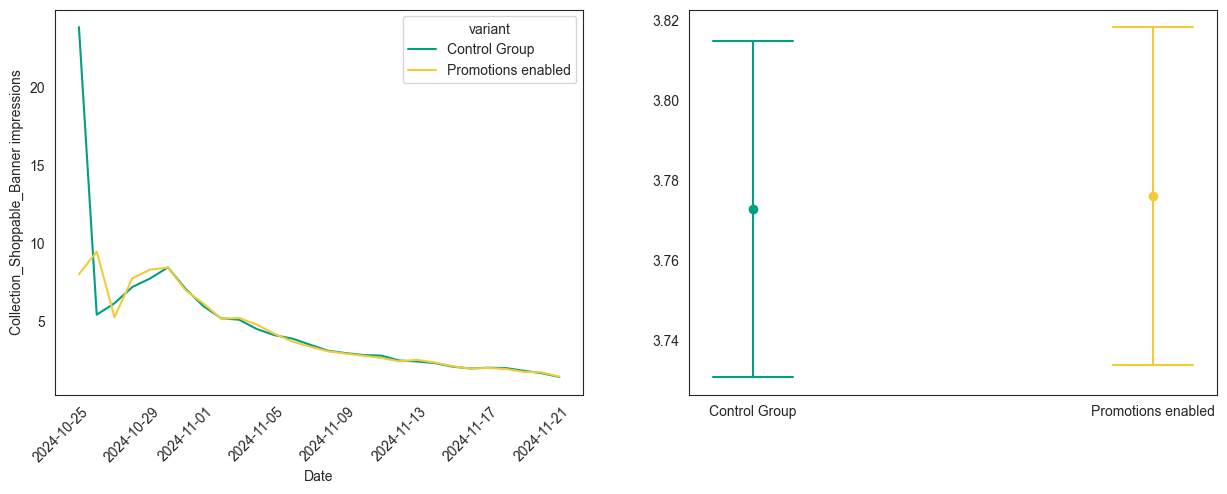

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DISTINCT COLLECTION_SHOPPABLE_BANNER IMPRESSIONS PER SESSION                                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,1.581391,1.586404,0.005013,-0.016077,0.026103,0.540403,0.008188,False


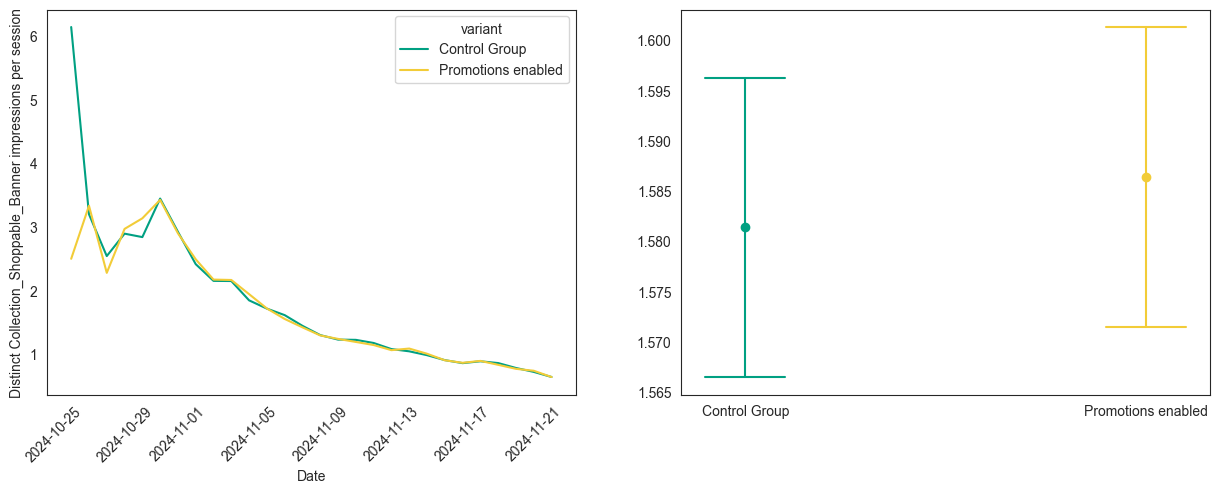

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ WIDGET COLLECTION IMPRESIONS                                                                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.000204,4.489568,4.489364,4.438575,4.540153,0.0,0.019718,True


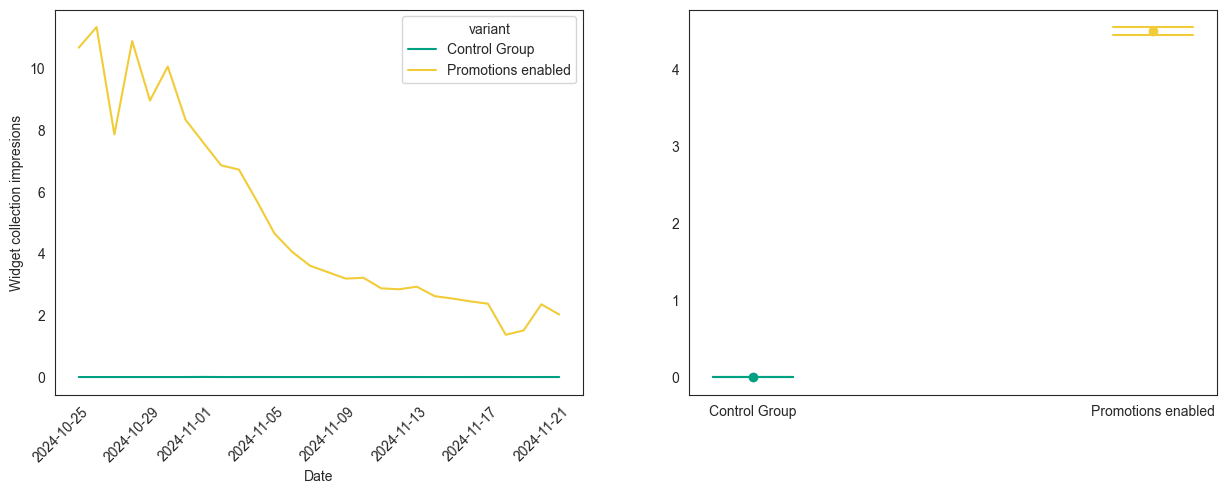

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ COLLECTION OPENED                                                                                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,21.547914,21.672681,0.124766,-0.146844,0.396377,0.236719,0.105446,False


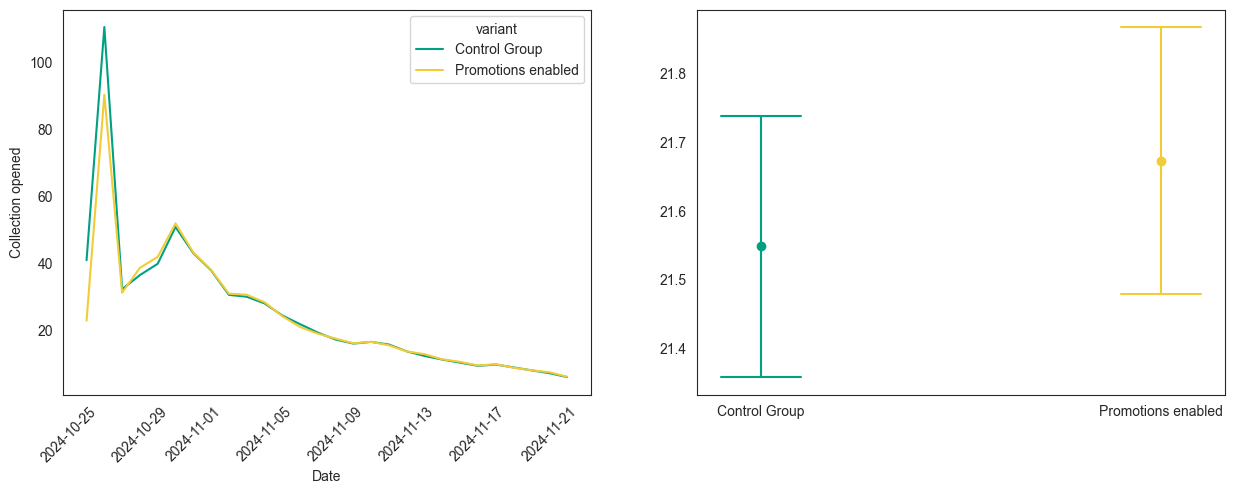

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DISTINCT COLLECTION OPENED PER SESSION                                                                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,16.420471,16.644392,0.223921,0.018915,0.428927,0.004901,0.079588,True


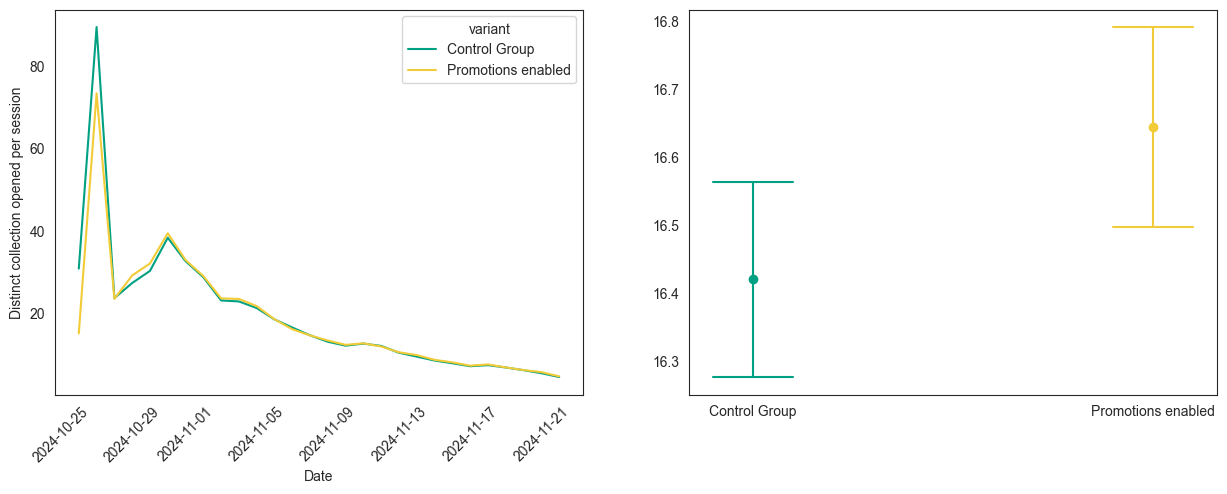

In [54]:
### Orders and GMV
from glovo_experimentation_analytics.analytics.experiment import Experiment

df['date'] = pd.to_datetime(df['first_exposure_at'])

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "New surfacing promotions will increase the number of customers that interact with Promotions",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "Collection_Shoppable_Banner impressions",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "banner_impressions",
            },   
            {
                "metric_name": "Distinct Collection_Shoppable_Banner impressions per session",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "distinct_banner_impressions_per_session",
            },
            {
                "metric_name": "Widget collection impresions",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "widget_collection_impressions",
            },  
            {
                "metric_name": "Collection opened",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "collection_opened",
            },   
            {
                "metric_name": "Distinct collection opened per session",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "distinct_collection_opened_per_session",
            },   
        ],    
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": True
    }

exp_fin = Experiment.from_dict(experiment_config)
exp_fin.full_analysis()